# Scoring and visualizing a single variant

Here we go through the process of predicting the effect of a single variant on
different modalities, such as gene expression and chromatin accessibility.

``` {tip}
Open this tutorial in Google colab for interactive viewing.
```

In [15]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Setup and imports

In [16]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation, genome, transcript, track_data
from alphagenome.models import dna_client, variant_scorers
from alphagenome.visualization import plot_components
from google.colab import data_table, files
import pandas as pd

data_table.DataTable.max_rows = 100_000
data_table.enable_dataframe_formatter()

# Load the model.
dna_model = dna_client.create(colab_utils.get_api_key())

HG38_GTF_FEATHER = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)
MM10_GTF_FEATHER = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'mm10/gencode.vM23.annotation.gtf.gz.feather'
)

# Initialize an empty dictionary to serve as a variant effect prediction cache.
_prediction_cache = {}

_transcript_extractor_cache = {}

## Score variant

In [25]:
# @title Score variant { run: "auto" }
organism = 'human'  # @param ["human", "mouse"] {type:"string"}
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
    'mouse': dna_client.Organism.MUS_MUSCULUS,
}
organism = organism_map[organism]

# @markdown Specify the variant:
variant_chromosome = 'chr22'  # @param { type:"string" }
variant_position = 36201698  # @param { type:"integer" }
variant_reference_bases = 'C'  # @param { type:"string" }
variant_alternate_bases = 'T'  # @param { type:"string" }

variant = genome.Variant(
    chromosome=variant_chromosome,
    position=variant_position,
    reference_bases=variant_reference_bases,
    alternate_bases=variant_alternate_bases,
)

# @markdown Specify length of sequence around variant to predict:
sequence_length = '1MB'  # @param ["2KB", "16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# The input interval is derived from the variant (centered on it).
interval = variant.reference_interval.resize(sequence_length)

# @markdown Additional settings:
variant_scores = dna_model.score_variant(
    interval=interval,
    variant=variant,
    variant_scorers=list(variant_scorers.RECOMMENDED_VARIANT_SCORERS.values()),
)

df_scores = variant_scorers.tidy_scores(variant_scores)

download_predictions = False  # @param { type: "boolean" }
if download_predictions:
  df_scores.to_csv(f'{variant}_scores.csv', index=False)
  files.download(f'{variant}_scores.csv')

# @markdown Click `Filter` on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the `Search by all fields box` to subset the variant scores to a specific tissue of interest:
columns = [
    c for c in df_scores.columns if c not in ['variant_id', 'scored_interval']
]
df_scores[columns]

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "Interval out of bounds for organism. 'chr22:67829266-68877842:.'."
	debug_error_string = "UNKNOWN:Error received from peer ipv4:74.125.201.95:443 {grpc_status:3, grpc_message:"Interval out of bounds for organism. \'chr22:67829266-68877842:.\'."}"
>

## Visualize variant effects

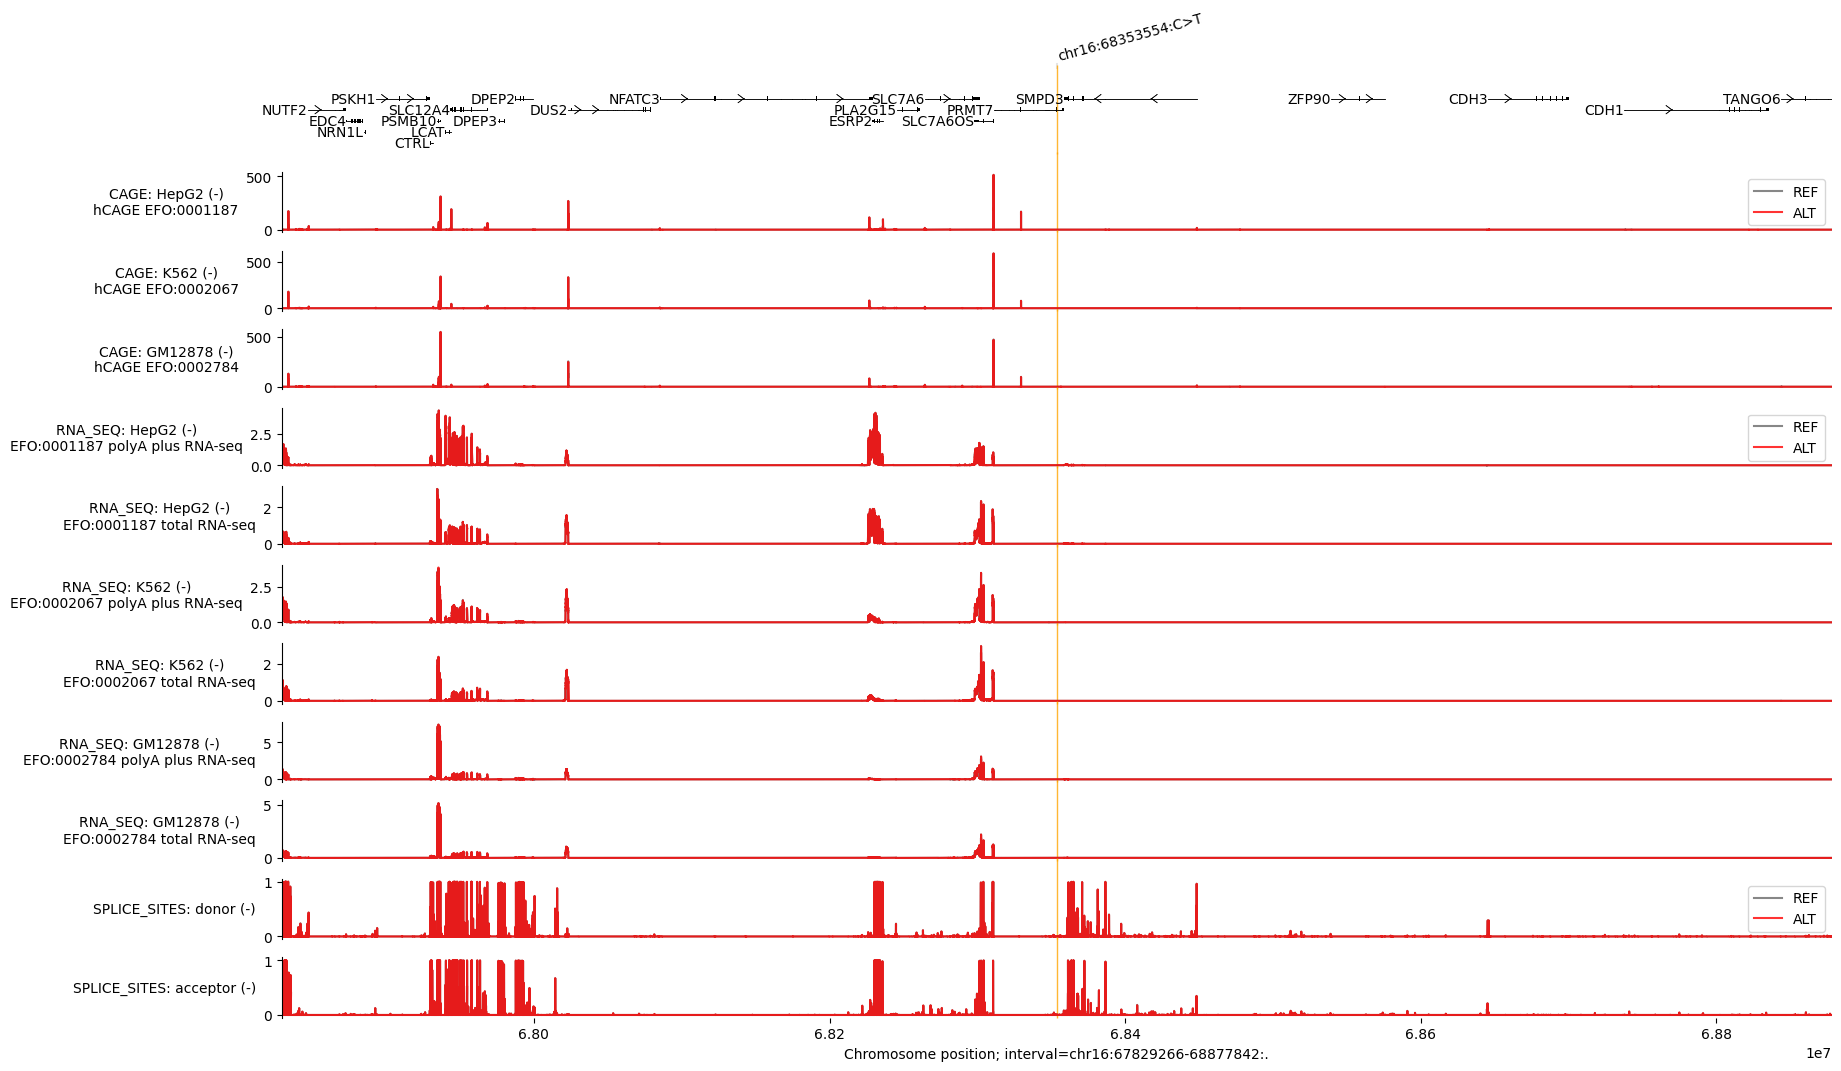

In [24]:
# @title Visualize variant effects { run: "auto" }
# @markdown We can also visualise the predicted effects of the variant by first predicting tracks for the REF and ALT alleles:

# @markdown Specify list of cell and tissue ontologies:
ontology_terms = ['EFO:0001187', 'EFO:0002067', 'EFO:0002784']  # @param

# @markdown Gene and transcript annotation options:
plot_gene_annotation = True  # @param { type: "boolean" }
plot_longest_transcript_only = True  # @param { type: "boolean" }

# @markdown Output types to plot (if present in output):
plot_rna_seq = True  # @param { type: "boolean" }
plot_cage = True  # @param { type: "boolean" }
plot_atac = False  # @param { type: "boolean" }
plot_dnase = False  # @param { type: "boolean" }
plot_chip_histone = False  # @param { type: "boolean" }
plot_chip_tf = False  # @param { type: "boolean" }
plot_splice_sites = True  # @param { type: "boolean" }
plot_splice_site_usage = False  # @param { type: "boolean" }
plot_contact_maps = False  # @param { type: "boolean" }
plot_splice_junctions = False  # @param { type: "boolean" }

# @markdown Option to filter tracks to only a specific DNA strand:
filter_to_positive_strand = False  # @param { type: "boolean" }
filter_to_negative_strand = True  # @param { type: "boolean" }
if filter_to_positive_strand and filter_to_negative_strand:
  raise ValueError(
      'Cannot specify both filter_to_positive_strand and '
      'filter_to_negative_strand.'
  )

# @markdown Specify a list of Transription Factors to select from CHIP_TF outputs e.g. ['IKZF1'].
# These must be contained in the 'transcription_factor' column of the CHIP_TF metadata.
transcription_factors = None  # @param

# @markdown Other visualization options:
ref_color = 'dimgrey'  # @param { type: "string" }
alt_color = 'red'  # @param { type: "string" }
ref_alt_colors = {'REF': ref_color, 'ALT': alt_color}
plot_interval_width = 1048576 # @param { type: "slider", min: 2048, max: 1048576, step: 2048}
plot_interval_shift = 0 # @param { type: "slider", min: -524288, max: 524288, step: 2048}


# Load gene annotation.
if organism in _transcript_extractor_cache:
  transcript_extractor, longest_transcript_extractor = (
      _transcript_extractor_cache[organism]
  )
else:
  match organism:
    case dna_client.Organism.HOMO_SAPIENS:
      gtf_path = HG38_GTF_FEATHER
    case dna_client.Organism.MUS_MUSCULUS:
      gtf_path = MM10_GTF_FEATHER
    case _:
      raise ValueError(f'Unsupported organism: {organism}')

  gtf = pd.read_feather(gtf_path)

  # Filter to protein-coding genes and highly supported transcripts.
  gtf_transcript = gene_annotation.filter_transcript_support_level(
      gene_annotation.filter_protein_coding(gtf), ['1']
  )

  # Extractor for identifying transcripts in a region.
  transcript_extractor = transcript.TranscriptExtractor(gtf_transcript)

  # Also define an extractor that fetches only the longest transcript per gene.
  gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
      gtf_transcript
  )
  longest_transcript_extractor = transcript.TranscriptExtractor(
      gtf_longest_transcript
  )
  _transcript_extractor_cache[organism] = (
      transcript_extractor,
      longest_transcript_extractor,
  )


def _predict_variant_cached(
    interval, variant, organism, requested_outputs, ontology_terms
):
  """Cache wrapper of dna_model.predict_variant."""
  # Create a unique key from the function arguments.
  cache_key = (
      str(interval),
      str(variant),
      str(organism),
      tuple(requested_outputs),
      tuple(ontology_terms),
  )

  # Check if the result is already in the cache.
  if cache_key in _prediction_cache:
    return _prediction_cache[cache_key]

  # If not, compute the prediction and store it in the cache.
  result = dna_model.predict_variant(
      interval=interval,
      variant=variant,
      organism=organism,
      requested_outputs=requested_outputs,
      ontology_terms=ontology_terms,
  )
  _prediction_cache[cache_key] = result
  return result


output = _predict_variant_cached(
    interval=interval,
    variant=variant,
    organism=organism,
    requested_outputs=[*dna_client.OutputType],
    ontology_terms=ontology_terms,
)

# Filter to DNA strand if requested.
ref, alt = output.reference, output.alternate

if filter_to_positive_strand:
  ref = ref.filter_to_strand(strand='+')
  alt = alt.filter_to_strand(strand='+')
elif filter_to_negative_strand:
  ref = ref.filter_to_strand(strand='-')
  alt = alt.filter_to_strand(strand='-')

# Function to filter to TFs if requested.


def _maybe_filter_to_tfs(
    tdata: track_data.TrackData,
) -> track_data.TrackData | None:
  if not plot_chip_tf:
    return tdata

  if plot_chip_tf and (transcription_factors is not None):
    if not isinstance(transcription_factors, list):
      raise ValueError('TFs must be input as a list of strings.')
    if not isinstance(transcription_factors[0], str):
      raise ValueError('TFs must be input as a list of strings.')

  if transcription_factors is None:
    return tdata

  tf_rows = tdata.metadata.index[
      tdata.metadata['transcription_factor'].isin(transcription_factors)
  ]
  if not tf_rows.any():
    print(
        f'No tracks found for specified transcription factors and'
        f' ontology_terms.'
    )
    return None
  missing_tfs = set(transcription_factors).difference(
      set(tdata.metadata['transcription_factor'])
  )
  if missing_tfs:
    print(
        f'Could not find tracks in chip_tf outputs corresponding to the'
        f' following requested TFs'
    )
  return tdata.select_tracks_by_index(tf_rows)


# Build plot.
components = []

# Gene and transcript annotation.
if plot_gene_annotation:
  if plot_longest_transcript_only:
    transcripts = longest_transcript_extractor.extract(interval)
  else:
    transcripts = transcript_extractor.extract(interval)
  components.append(plot_components.TranscriptAnnotation(transcripts))


# Individual output type plots.
plot_map = {
    'plot_atac': (ref.atac, alt.atac, 'ATAC'),
    'plot_cage': (ref.cage, alt.cage, 'CAGE'),
    'plot_chip_histone': (ref.chip_histone, alt.chip_histone, 'CHIP_HISTONE'),
    'plot_chip_tf': (
        _maybe_filter_to_tfs(ref.chip_tf),
        _maybe_filter_to_tfs(alt.chip_tf),
        'CHIP_TF',
    ),
    'plot_contact_maps': (ref.contact_maps, alt.contact_maps, 'CONTACT_MAPS'),
    'plot_dnase': (ref.dnase, alt.dnase, 'DNASE'),
    'plot_rna_seq': (ref.rna_seq, alt.rna_seq, 'RNA_SEQ'),
    'plot_splice_junctions': (
        ref.splice_junctions,
        alt.splice_junctions,
        'SPLICE_JUNCTIONS',
    ),
    'plot_splice_sites': (ref.splice_sites, alt.splice_sites, 'SPLICE_SITES'),
    'plot_splice_site_usage': (
        ref.splice_site_usage,
        alt.splice_site_usage,
        'SPLICE_SITE_USAGE',
    ),
}

for key, (ref_data, alt_data, output_type) in plot_map.items():
  if eval(key) and ref_data is not None and ref_data.values.shape[-1] == 0:
    print(
        f'Requested plot for output {output_type} but no tracks exist in'
        ' output. This is likely because this output does not exist for your'
        ' ontologies or requested DNA strand.'
    )
  if eval(key) and ref_data and alt_data:
    match output_type:
      case 'CHIP_HISTONE':
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{histone_mark}}'
        )
      case 'CHIP_TF':
        ylabel_template = (
            f'{output_type}: {{biosample_name}}'
            ' ({strand})\n{transcription_factor}'
        )
      case 'CONTACT_MAPS':
        ylabel_template = f'{output_type}: {{biosample_name}} ({{strand}})'
      case 'SPLICE_SITES':
        ylabel_template = f'{output_type}: {{name}} ({{strand}})'
      case _:
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{name}}'
        )

    if output_type == 'CONTACT_MAPS':
      component = plot_components.ContactMapsDiff(
          tdata=alt_data - ref_data,
          ylabel_template=ylabel_template,
      )
      components.append(component)
    elif output_type == 'SPLICE_JUNCTIONS':
      ref_plot = plot_components.Sashimi(
          ref_data,
          ylabel_template='REF: ' + ylabel_template,
      )
      alt_plot = plot_components.Sashimi(
          alt_data,
          ylabel_template='ALT: ' + ylabel_template,
      )
      components.extend([ref_plot, alt_plot])
    else:
      component = plot_components.OverlaidTracks(
          tdata={'REF': ref_data, 'ALT': alt_data},
          colors=ref_alt_colors,
          ylabel_template=ylabel_template,
      )
      components.append(component)

if plot_interval_width > interval.width:
  raise ValueError(
      f'plot_interval_width ({plot_interval_width}) must be less than '
      f'interval.width ({interval.width}).'
  )

plot = plot_components.plot(
    components=components,
    interval=interval.shift(plot_interval_shift).resize(plot_interval_width),
    annotations=[
        plot_components.VariantAnnotation([variant]),
    ],
)